In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self,inchannel,outchannel,stride=1):
        super(ResidualBlock,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(inchannel,outchannel,kernel_size=3,padding=1,stride=stride),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel,outchannel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(outchannel),
        )
        self.conv1x1 = nn.Sequential( 
            nn.Conv2d(inchannel,outchannel,kernel_size=1,stride=stride),
            nn.BatchNorm2d(outchannel)
            )
    def forward(self,X):
        Y = self.conv(X)
        X = self.conv1x1(X)
        out = F.relu(X+Y)
        return out

In [3]:
block1 =  ResidualBlock(64,64,1)
block2 =  ResidualBlock(64,64,1)
block3 =  ResidualBlock(64,128,2)
block4 =  ResidualBlock(128,128,1)
block5 =  ResidualBlock(128,256,2)
block6 =  ResidualBlock(256,256,1)
block7 =  ResidualBlock(256,512,2)
block8 =  ResidualBlock(512,512,1)

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(kernel_size=3,in_channels=3,out_channels=64,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            block1,block2,block3,block4,block5,block6,block7,block8
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(512,3)
        )
    
    def forward(self,X):
        features = self.features(X)
        out = self.classifier(features)
        return out

In [4]:
device = torch.device("cuda")

In [5]:
# 数据增强 镜像操作/直方图均衡化
# car 779 truck 360 bus 218
import os
import cv2 as cv

bus_path = '/home/hatcher/test/deep-learning/VehicleDataset/bus'
car_path = '/home/hatcher/test/deep-learning/VehicleDataset/car'
truck_path = '/home/hatcher/test/deep-learning/VehicleDataset/truck'
bus_pics = os.listdir(bus_path)
car_pics = os.listdir(car_path)
truck_pics = os.listdir(truck_path)
bus_list, car_list, truck_list = [], [], []

for bus_pic in bus_pics:
    img = cv.imread(bus_path+"/"+bus_pic)
    img = cv.resize(img, (227, 227))
    flip_img = cv.flip(img, 1)
    equ_img = cv.equalizeHist(cv.cvtColor(img,cv.COLOR_BGR2GRAY))
    equ_img=cv.cvtColor(equ_img,cv.COLOR_GRAY2BGR)
    img = img/255
    bus_list.append(img)
    flip_img = flip_img/255
    bus_list.append(flip_img)
    equ_img = equ_img/255
    bus_list.append(equ_img)

for car_pic in car_pics:
    img = cv.imread(car_path+"/"+car_pic)
    img = cv.resize(img, (227, 227))
    img = img/255
    car_list.append(img)

for truck_pic in truck_pics:
    img = cv.imread(truck_path+"/"+truck_pic)
    img = cv.resize(img, (227, 227))
    flip_img = cv.flip(img, 1)
    img = img/255
    truck_list.append(img)
    flip_img = flip_img/255
    truck_list.append(flip_img)

bus_length = len(bus_list)
car_length = len(car_list)
truck_length = len(truck_list)
num_bus_train = int(len(bus_list)*0.8)
num_car_train = int(len(car_list)*0.8)
num_truck_train = int(len(truck_list)*0.8)
train_y,test_y=[],[]
for i in range(num_bus_train):
    #train_y.append([1,0,0,0,0,0,0,0,0,0])
    train_y.append([1,0,0])
for i in range(num_car_train):
    #train_y.append([0,1,0,0,0,0,0,0,0,0])
    train_y.append([0,1,0])
for i in range(num_truck_train):
    #train_y.append([0,0,1,0,0,0,0,0,0,0])
    train_y.append([0,0,1])
for i in range(num_bus_train,bus_length):
    #test_y.append([1,0,0,0,0,0,0,0,0,0])
    test_y.append([1,0,0])
for i in range(num_car_train,car_length):
    #test_y.append([0,1,0,0,0,0,0,0,0,0])
    test_y.append([0,1,0])
for i in range(num_truck_train,truck_length):
    #test_y.append([0,0,1,0,0,0,0,0,0,0])
    test_y.append([0,0,1])
train_x,test_x=[],[]
for i in range(num_bus_train):
    train_x.append(bus_list[i])
for i in range(num_car_train):
    train_x.append(car_list[i])
for i in range(num_truck_train):
    train_x.append(truck_list[i])
for i in range(num_bus_train,bus_length):
    test_x.append(bus_list[i])
for i in range(num_car_train,car_length):
    test_x.append(car_list[i])
for i in range(num_truck_train,truck_length):
    test_x.append(truck_list[i])

train_x = torch.Tensor(train_x).permute(0,3,1,2)
test_x = torch.Tensor(test_x).permute(0,3,1,2)
train_y = torch.Tensor(train_y)
test_y = torch.Tensor(test_y)
print("train_x:",train_x.size())
print("test_x:",test_x.size())
print("train_y:",train_y.size())
print("test_y:",test_y.size())
train_x = train_x[1:1701,:,:,:]
test_x = test_x[1:431,:,:,:]
train_y = train_y[1:1701,:]
test_y = test_y[1:431,:]
print("train_x:",train_x.size())
print("test_x:",test_x.size())
print("train_y:",train_y.size())
print("test_y:",test_y.size())

/tmp/ipykernel_276121/344122819.py:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  train_x = torch.Tensor(train_x).permute(0,3,1,2)


train_x: torch.Size([1722, 3, 227, 227])
test_x: torch.Size([431, 3, 227, 227])
train_y: torch.Size([1722, 3])
test_y: torch.Size([431, 3])
train_x: torch.Size([1700, 3, 227, 227])
test_x: torch.Size([430, 3, 227, 227])
train_y: torch.Size([1700, 3])
test_y: torch.Size([430, 3])


In [6]:
import torch.utils.data as Data
batch_size = 10# 将训练数据的特征和标签组合
train_dataset,test_dataset = Data.TensorDataset(train_x, train_y),Data.TensorDataset(test_x, test_y)
# 把 dataset 放入 DataLoader
train_iter = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
test_iter = Data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True,num_workers=2)

In [7]:
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        #y_hat = y_hat.view(1,-1) 
        acc_sum += (y_hat.argmax(dim=1) == y.argmax(dim=1)).sum().item()
        l = loss(y_hat, y).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

In [8]:
def train(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    train_loss=[]
    test_loss=[]
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            y = y.to(device)
            #print(y.size())
            y_hat = net(X)
            y_hat = y_hat.squeeze()
            #y_hat = y_hat.view(1,-1) 
            #print(y_hat.size())
            l=loss(y_hat,y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params,lr)
            else:
                optimizer.step()
            train_l_sum+=l.item()
            '''print(y_hat.shape)
            print(y.shape)
            print(y_hat)
            print(y_hat.argmax(dim=1))
            print(y)
            print(y_hat.argmax(dim=1)==y)
            '''
            train_acc_sum+=(y_hat.argmax(dim=1)==y.argmax(dim=1)).sum().item()
            n+=y.shape[0]
        test_acc,test_l = evaluate_accuracy(test_iter,net,loss)
        train_loss.append(train_l_sum/n)
        test_loss.append(test_l)
        print('epoch%d,loss%.4f,train acc %3f,test acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,test_acc))
    return train_loss,test_loss

In [9]:
num_epochs=40
lr=0.03
loss=nn.CrossEntropyLoss()
net = ResNet()
net.to(device)
optimizer=torch.optim.SGD(net.parameters(),lr)
for params in net.parameters():
    nn.init.normal_(params,mean=0,std=0.01)

In [10]:
train_loss,test_loss=train(net,train_iter,test_iter,loss,num_epochs,batch_size,net.parameters(),lr,optimizer)

epoch1,loss0.1098,train acc 0.360588,test acc 0.363
epoch2,loss0.1096,train acc 0.366471,test acc 0.363
epoch3,loss0.1090,train acc 0.377647,test acc 0.428
epoch4,loss0.1033,train acc 0.527059,test acc 0.577
epoch5,loss0.0909,train acc 0.568824,test acc 0.572
epoch6,loss0.0846,train acc 0.588824,test acc 0.593
epoch7,loss0.0812,train acc 0.585882,test acc 0.628
epoch8,loss0.0779,train acc 0.616471,test acc 0.605
epoch9,loss0.0762,train acc 0.634706,test acc 0.756
epoch10,loss0.0717,train acc 0.742941,test acc 0.784
epoch11,loss0.0601,train acc 0.791176,test acc 0.805
epoch12,loss0.0527,train acc 0.810588,test acc 0.816
epoch13,loss0.0481,train acc 0.831765,test acc 0.812
epoch14,loss0.0471,train acc 0.834118,test acc 0.826
epoch15,loss0.0416,train acc 0.845882,test acc 0.840
epoch16,loss0.0398,train acc 0.855882,test acc 0.858
epoch17,loss0.0388,train acc 0.855294,test acc 0.860
epoch18,loss0.0326,train acc 0.892941,test acc 0.840
epoch19,loss0.0346,train acc 0.880588,test acc 0.886
ep

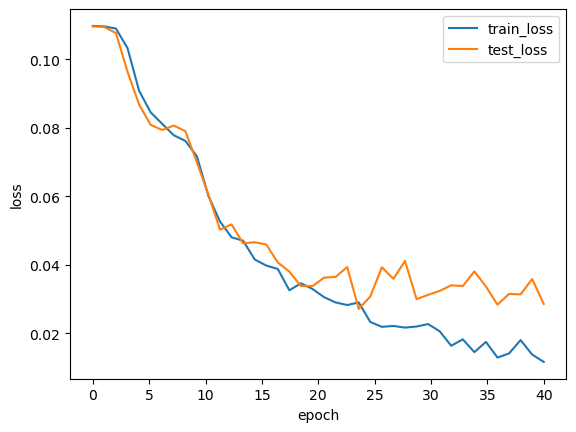

In [11]:
import matplotlib.pyplot as plt
import numpy as np
x=np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label='train_loss',linewidth=1.5)
plt.plot(x,test_loss,label='test_loss',linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()